In [69]:
! python -V

Python 3.12.4


In [70]:
import math
import time
import random
import numpy as np
import json
from concurrent.futures import ProcessPoolExecutor
import multiprocessing as mp
from bessel_zeros import get_bessel_zeros
from scipy.special import jv, jvp, gamma, loggamma
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import matplotlib.patches as patches
font = font_manager.FontProperties(style='normal', size=20)
import matplotlib.ticker as ticker
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')

from bessel_zeros import get_bessel_zeros
from CDFs3_working import build_cdfs as build_cdfs
import seaborn as sns

In [ ]:
# open a json file to save path lengths
d = 20
with open(f"path_length_{d}.json", 'r') as json_file:
        # Use json.load() to convert the file content into a Python dictionary
        length_dict = json.load(json_file)


In [124]:
avg_length = np.array([[s, np.mean(length)] for s, length in length_dict.items()])
avg_length = avg_length.astype(float)
np.round(avg_length,3,out=None)

array([[2.00000e-01, 2.22180e+01],
       [4.00000e-01, 7.09230e+01],
       [6.00000e-01, 1.13196e+02],
       [8.00000e-01, 1.54908e+02],
       [1.00000e+00, 1.96539e+02],
       [1.20000e+00, 2.38107e+02],
       [1.40000e+00, 2.79627e+02],
       [1.60000e+00, 3.21211e+02],
       [1.80000e+00, 3.62761e+02],
       [2.00000e+00, 4.04211e+02]])

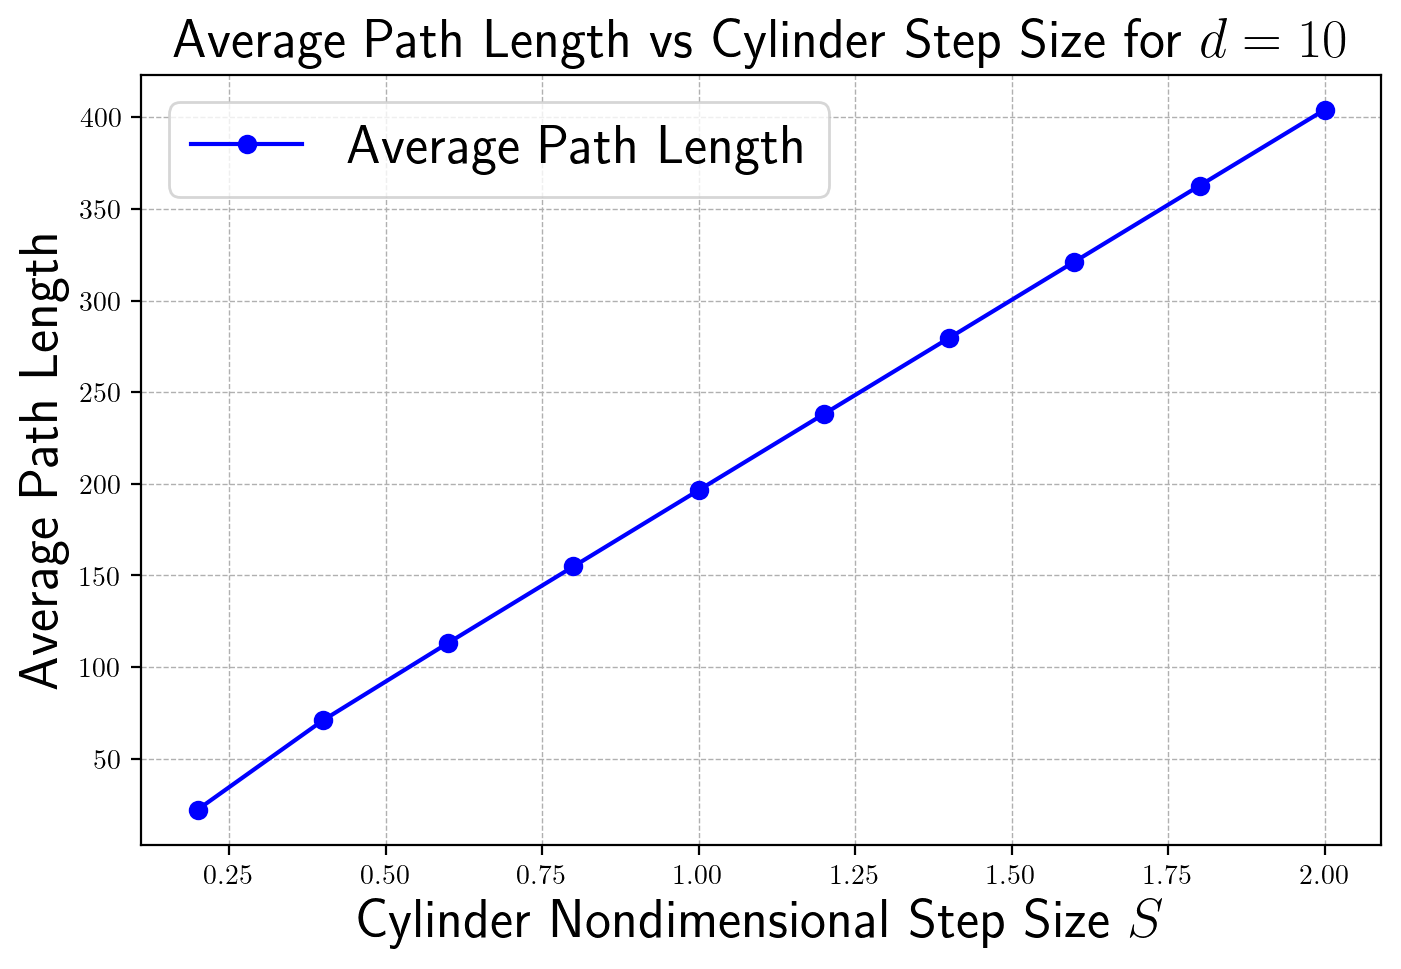

In [125]:
# ── PLOTTING ────────────────────────────────────────────────────────────────
f , ax = plt.subplots(figsize=(8, 5),dpi=200)
ax.plot(avg_length[:,0], avg_length[:,1], marker='o', linestyle='-', color='blue', label='Average Path Length')
plt.xlabel('Cylinder Nondimensional Step Size $S$', fontproperties=font)
plt.ylabel('Average Path Length', fontproperties=font)
plt.title(f'Average Path Length vs Cylinder Step Size for $d={d}$', fontproperties=font)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(prop=font)
plt.show()
f.savefig(f'avg_path_length_{d}.pdf',format="pdf",dpi=600)

In [126]:
#finding the slopes
(avg_length[1:,1] - avg_length[:-1,1]) / (avg_length[1:,0] - avg_length[:-1,0])

array([243.5214, 211.3662, 208.562 , 208.1539, 207.8419, 207.5997,
       207.92  , 207.7486, 207.2498])